In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 0

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

#data_path = "../../dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"
data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(index))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)

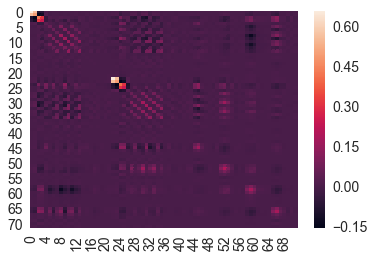

In [4]:
import seaborn as sns

sns.heatmap(P[0].reshape(dim, dim))

# Utilities 

In [5]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer_standard

def mf_initializer(mol):
    mf = mf_initializer_standard(mol)
    mf.max_cycle = 200
    return mf

In [6]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [7]:
print(make_results_str(measure_all_quantities(
    p_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.12497E-17 +- 7.51562E-18
--- Occupance Error ---
5.52350E-15 +- 4.74069E-15
--- HF Energy Error ---
1.23019E-14 +- 1.25744E-14
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



# Pure blocks

i will now set all other elements zero

## Utilities

In [8]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[0][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

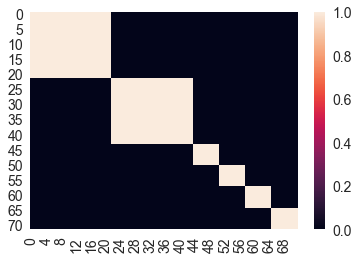

In [9]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [10]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0
    return p_batch

p_pure = np.array(list(map(extract_pure, p_test))).astype("float64")

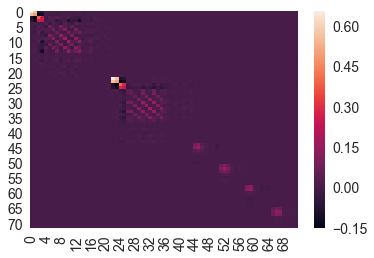

In [11]:
sns.heatmap(p_pure[0])

In [12]:
print(make_results_str(measure_all_quantities(
    p_pure,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
8.16693E-03 +- 6.72978E-03
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
8.43554E-03 +- 1.43849E-03
--- Occupance Error ---
3.09858E+00 +- 6.44510E-01
--- HF Energy Error ---
4.31669E+00 +- 1.13094E+00
--- Avg. Iterations ---
3.66965E+01 +- 3.98464E+01
--- Num. Not Convd. ---
11



# Embedding the Blocks In Classical Guesses

In [13]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


## Convergedn in Converged 

In [14]:
p_test_test = embedd_batch(p_test)

In [15]:
print(make_results_str(measure_all_quantities(
    p_test_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.12497E-17 +- 7.51562E-18
--- Occupance Error ---
5.52350E-15 +- 4.74069E-15
--- HF Energy Error ---
1.04637E-14 +- 1.17333E-14
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



## SAD 

In [16]:
from pyscf.scf import hf

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

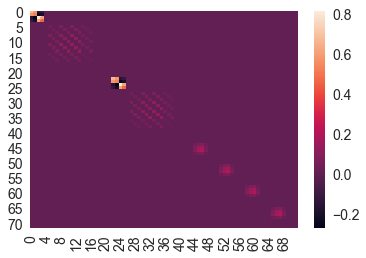

In [17]:
sns.heatmap(p_sad[0])

In [18]:
print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.17947E-02 +- 9.59898E-03
--- Symmetry Error ---
5.53389E-20 +- 1.19860E-20
--- Idempotence Error ---
1.16993E-02 +- 5.89657E-04
--- Occupance Error ---
3.79133E-15 +- 3.38382E-15
--- HF Energy Error ---
4.82823E-01 +- 2.46663E-01
--- Avg. Iterations ---
2.49652E+01 +- 8.31972E+00
--- Num. Not Convd. ---
0



## Embedded SAD

In [19]:
p_embedded_sad = embedd_batch(p_sad)

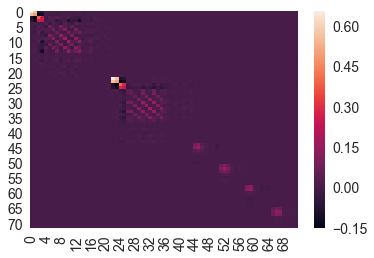

In [20]:
sns.heatmap(p_embedded_sad[0])

In [21]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
8.16693E-03 +- 6.72978E-03
--- Symmetry Error ---
2.37282E-32 +- 1.48288E-32
--- Idempotence Error ---
8.43554E-03 +- 1.43849E-03
--- Occupance Error ---
3.09858E+00 +- 6.44510E-01
--- HF Energy Error ---
4.31669E+00 +- 1.13094E+00
--- Avg. Iterations ---
3.66965E+01 +- 3.98464E+01
--- Num. Not Convd. ---
11



## GWH

In [22]:
p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

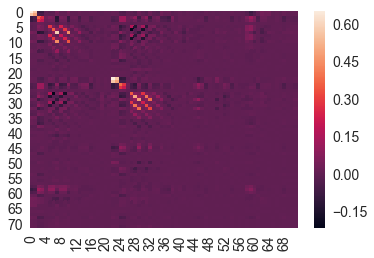

In [23]:
sns.heatmap(p_gwh[0])

In [24]:
print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.44241E-02 +- 1.08830E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
2.51096E-17 +- 4.94844E-18
--- Occupance Error ---
3.72947E-15 +- 3.38993E-15
--- HF Energy Error ---
4.92599E+00 +- 4.65357E-01
--- Avg. Iterations ---
1.91114E+02 +- 3.70334E+01
--- Num. Not Convd. ---
190



## Embedded GWH 

In [25]:
p_embedded_gwh = embedd_batch(p_gwh)

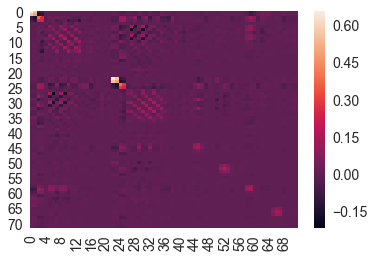

In [26]:
sns.heatmap(p_embedded_gwh[0])

In [27]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
9.31615E-03 +- 6.43439E-03
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
1.27474E-02 +- 2.22540E-03
--- Occupance Error ---
1.48118E+00 +- 5.81395E-01
--- HF Energy Error ---
1.88674E+00 +- 8.99107E-01
--- Avg. Iterations ---
2.49254E+01 +- 6.58427E+00
--- Num. Not Convd. ---
0



# McWheeny

In [28]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test):
        p_res.append(multi_mc_wheeny(p, s, 5))
    return np.asarray(p_res)

## GWH 

In [29]:
p_embedded_gwh_mcw5 = multi_mc_wheeny_batch(p_embedded_gwh)

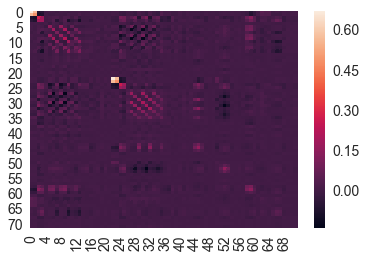

In [30]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [31]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

/home/jo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


--- Absolute Error ---
1.94133E+97 +- 5.11055E+98
--- Symmetry Error ---
1.44316E+82 +- 2.04094E+83
--- Idempotence Error ---
6.56885E+199 +- INF
--- Occupance Error ---
1.68342E+100 +- 2.38072E+101
--- HF Energy Error ---
6.09045E+201 +- INF
--- Avg. Iterations ---
6.77910E+01 +- 7.53761E+01
--- Num. Not Convd. ---
49



## SAD 

In [32]:
p_embedded_sad_mcw5 = multi_mc_wheeny_batch(p_embedded_sad)

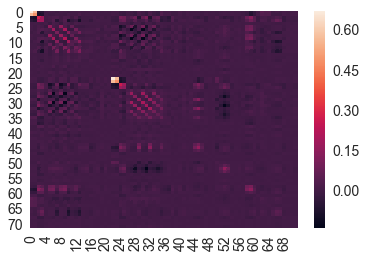

In [33]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [34]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

/home/jo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


--- Absolute Error ---
3.75947E+76 +- 1.05633E+78
--- Symmetry Error ---
4.16897E+61 +- 5.89582E+62
--- Idempotence Error ---
2.80318E+158 +- INF
--- Occupance Error ---
3.70961E+79 +- 5.24617E+80
--- HF Energy Error ---
2.89736E+160 +- INF
--- Avg. Iterations ---
1.26209E+02 +- 8.46347E+01
--- Num. Not Convd. ---
114



# Embedd Outer 

In [35]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_outer(x, y):
    p = x.copy()
    p[np.logical_not(mask)] = (y.copy())[np.logical_not(mask)]
    return p

def embedd_batch_outer(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_outer(p_guess, p_conv))
    return np.array(p_embedded)

## Converged 

In [36]:
print(make_results_str(measure_all_quantities(
    embedd_batch_outer(p_test),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.12497E-17 +- 7.51562E-18
--- Occupance Error ---
5.52350E-15 +- 4.74069E-15
--- HF Energy Error ---
1.32210E-14 +- 1.27982E-14
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



In [37]:
print(make_results_str(measure_all_quantities(
    embedd_batch_outer(p_embedded_sad),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.12497E-17 +- 7.51562E-18
--- Occupance Error ---
5.52350E-15 +- 4.74069E-15
--- HF Energy Error ---
1.13121E-14 +- 1.26248E-14
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



## SAD 

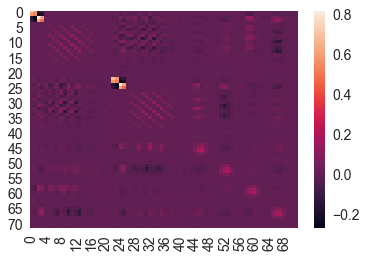

In [38]:
p_embedded_outer_sad = embedd_batch_outer(p_sad)
sns.heatmap(p_embedded_outer_sad[0])

In [39]:
print(make_results_str(measure_all_quantities(
    p_embedded_outer_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
3.62779E-03 +- 3.80144E-03
--- Symmetry Error ---
5.53389E-20 +- 1.19860E-20
--- Idempotence Error ---
1.45952E-02 +- 2.40083E-03
--- Occupance Error ---
3.09858E+00 +- 6.44510E-01
--- HF Energy Error ---
1.90470E+00 +- 2.55738E-01
--- Avg. Iterations ---
8.79701E+01 +- 8.02595E+01
--- Num. Not Convd. ---
68



## GWH 

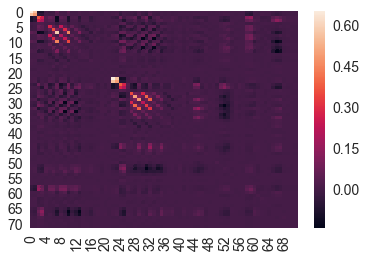

In [40]:
p_embedded_outer_gwh = embedd_batch_outer(p_gwh)
sns.heatmap(p_embedded_outer_gwh[0])

In [41]:
print(make_results_str(measure_all_quantities(
    p_embedded_outer_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
5.10794E-03 +- 5.55735E-03
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
1.34855E-02 +- 2.28148E-03
--- Occupance Error ---
1.48118E+00 +- 5.81395E-01
--- HF Energy Error ---
4.25139E+00 +- 7.06786E-01
--- Avg. Iterations ---
1.94403E+02 +- 2.95036E+01
--- Num. Not Convd. ---
194

